#Zasoby

* Build and use a classification model on census data

* https://cloud.google.com/bigquery/docs/e2e-journey

* https://cloud.google.com/bigquery/docs/logistic-regression-prediction



#Cele

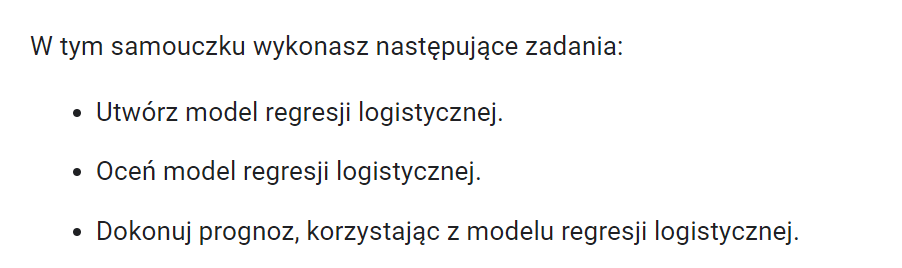

#Sprawdź swoje dane (Krok 1)

In [ ]:
%%bigquery

SELECT
  age,
  workclass, # rodzaj pracy
  marital_status,
  education_num, # poziom wykrztałcenia
  occupation,
  hours_per_week,
  income_bracket
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
LIMIT
  100;

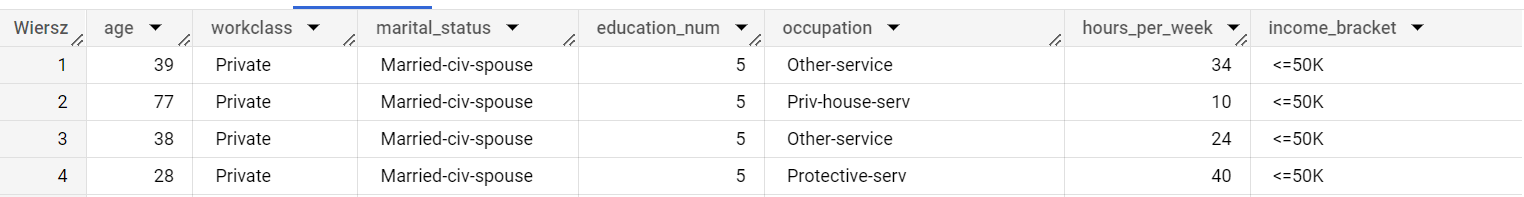

#Wybierz dane treningowe (Krok 2)

* Poniższe zapytanie tworzy widok, który kompiluje dane szkoleniowe. Ten widok jest uwzględniony w `CREATE MODEL`
* kolumna `functional_weight` to liczba ludności

In [ ]:
%%bigquery

CREATE OR REPLACE VIEW
`pmackowka_us.view_007` AS

SELECT
  age,
  workclass, # rodzaj pracy
  marital_status,
  education_num, # poziom wykrztałcenia
  occupation,
  hours_per_week,
  income_bracket,
  CASE
    # Oblicza resztę z dzielenia przez 10
    WHEN MOD(functional_weight, 10) < 8 THEN 'training' # 80% danych na potrzeby uczenia
    WHEN MOD(functional_weight, 10) = 8 THEN 'evaluation' # na potrzeby ewaluacji
    WHEN MOD(functional_weight, 10) = 9 THEN 'prediction' # na potrzeby przewidywania
  END AS dataframe

FROM
  `bigquery-public-data.ml_datasets.census_adult_income`

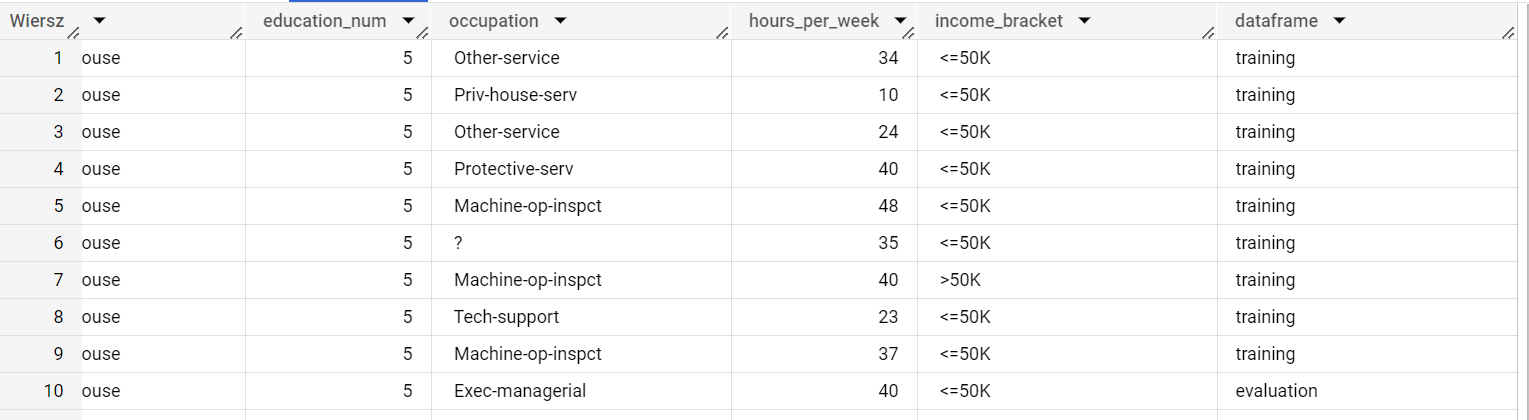

#Utwórz model regresji logistycznej (Krok 3)

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  `pmackowka_us.model_0071`
OPTIONS
  ( model_type='LOGISTIC_REG',

    # TRUE | FALSE
    # Aby zrównoważyć każdą klasę, ustaw AUTO_CLASS_WEIGHTS na TRUE. Kiedy dane są niezrównoważone.
    auto_class_weights=TRUE,

    # Kolumna etykiety
    input_label_cols=['income_bracket']

  ) AS

SELECT
  * EXCEPT(dataframe)
FROM
  `pmackowka_us.view_007`
WHERE
  dataframe = 'training'

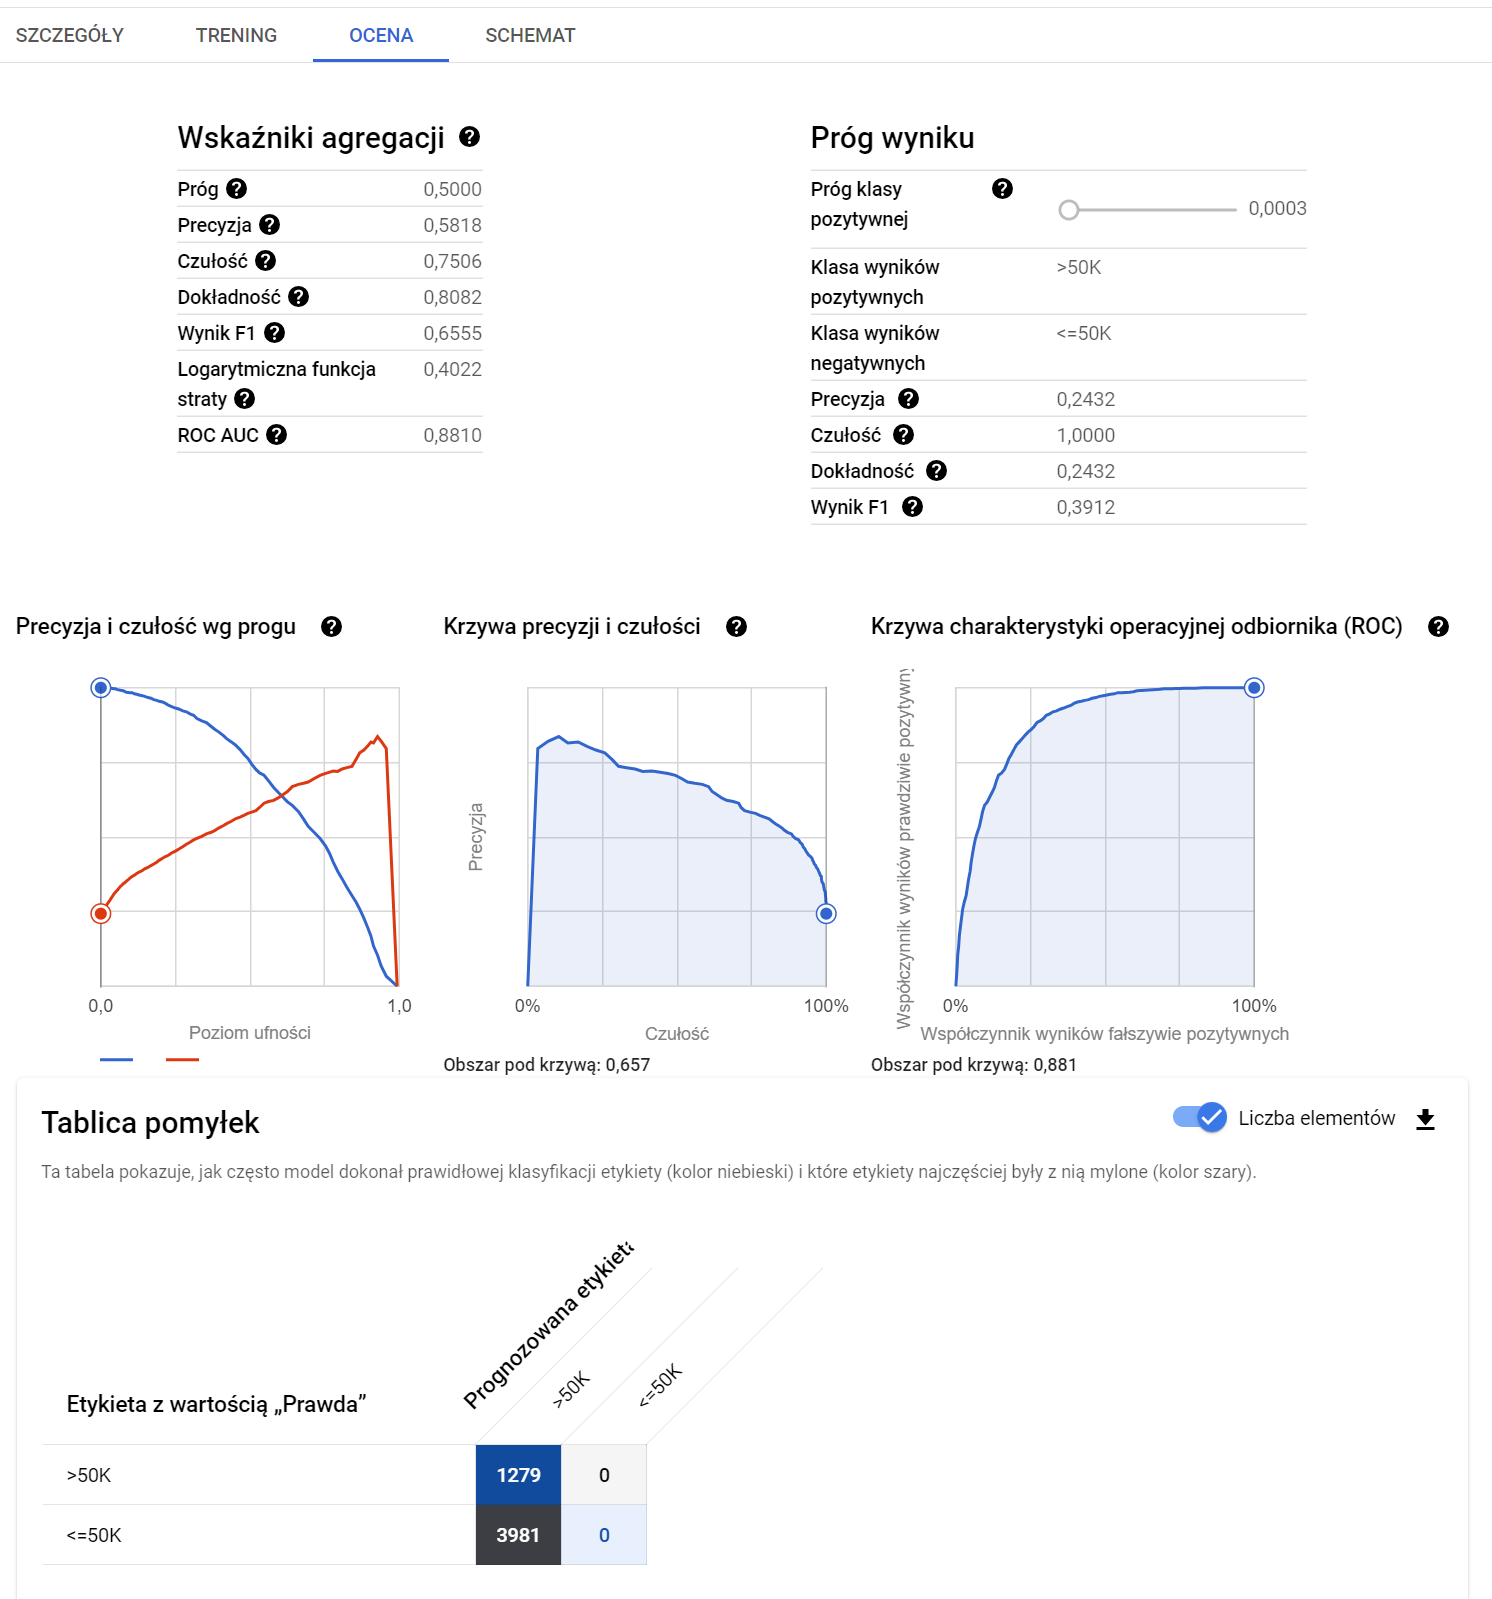

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL
  `pmackowka_us.model_0073`
OPTIONS
  ( model_type='LOGISTIC_REG',

    auto_class_weights=TRUE,

    # 'AUTO_SPLIT' | 'RANDOM' | 'CUSTOM' | 'SEQ' | 'NO_SPLIT'
    # 'NO_SPLIT' Wykorzystaj wszystkie dane jako dane treningowe.
    data_split_method='NO_SPLIT',

    input_label_cols=['income_bracket'],

    max_iterations=15
    ) AS
SELECT
  * EXCEPT(dataframe)
FROM
  `pmackowka_us.view_007`
WHERE
  dataframe = 'training'

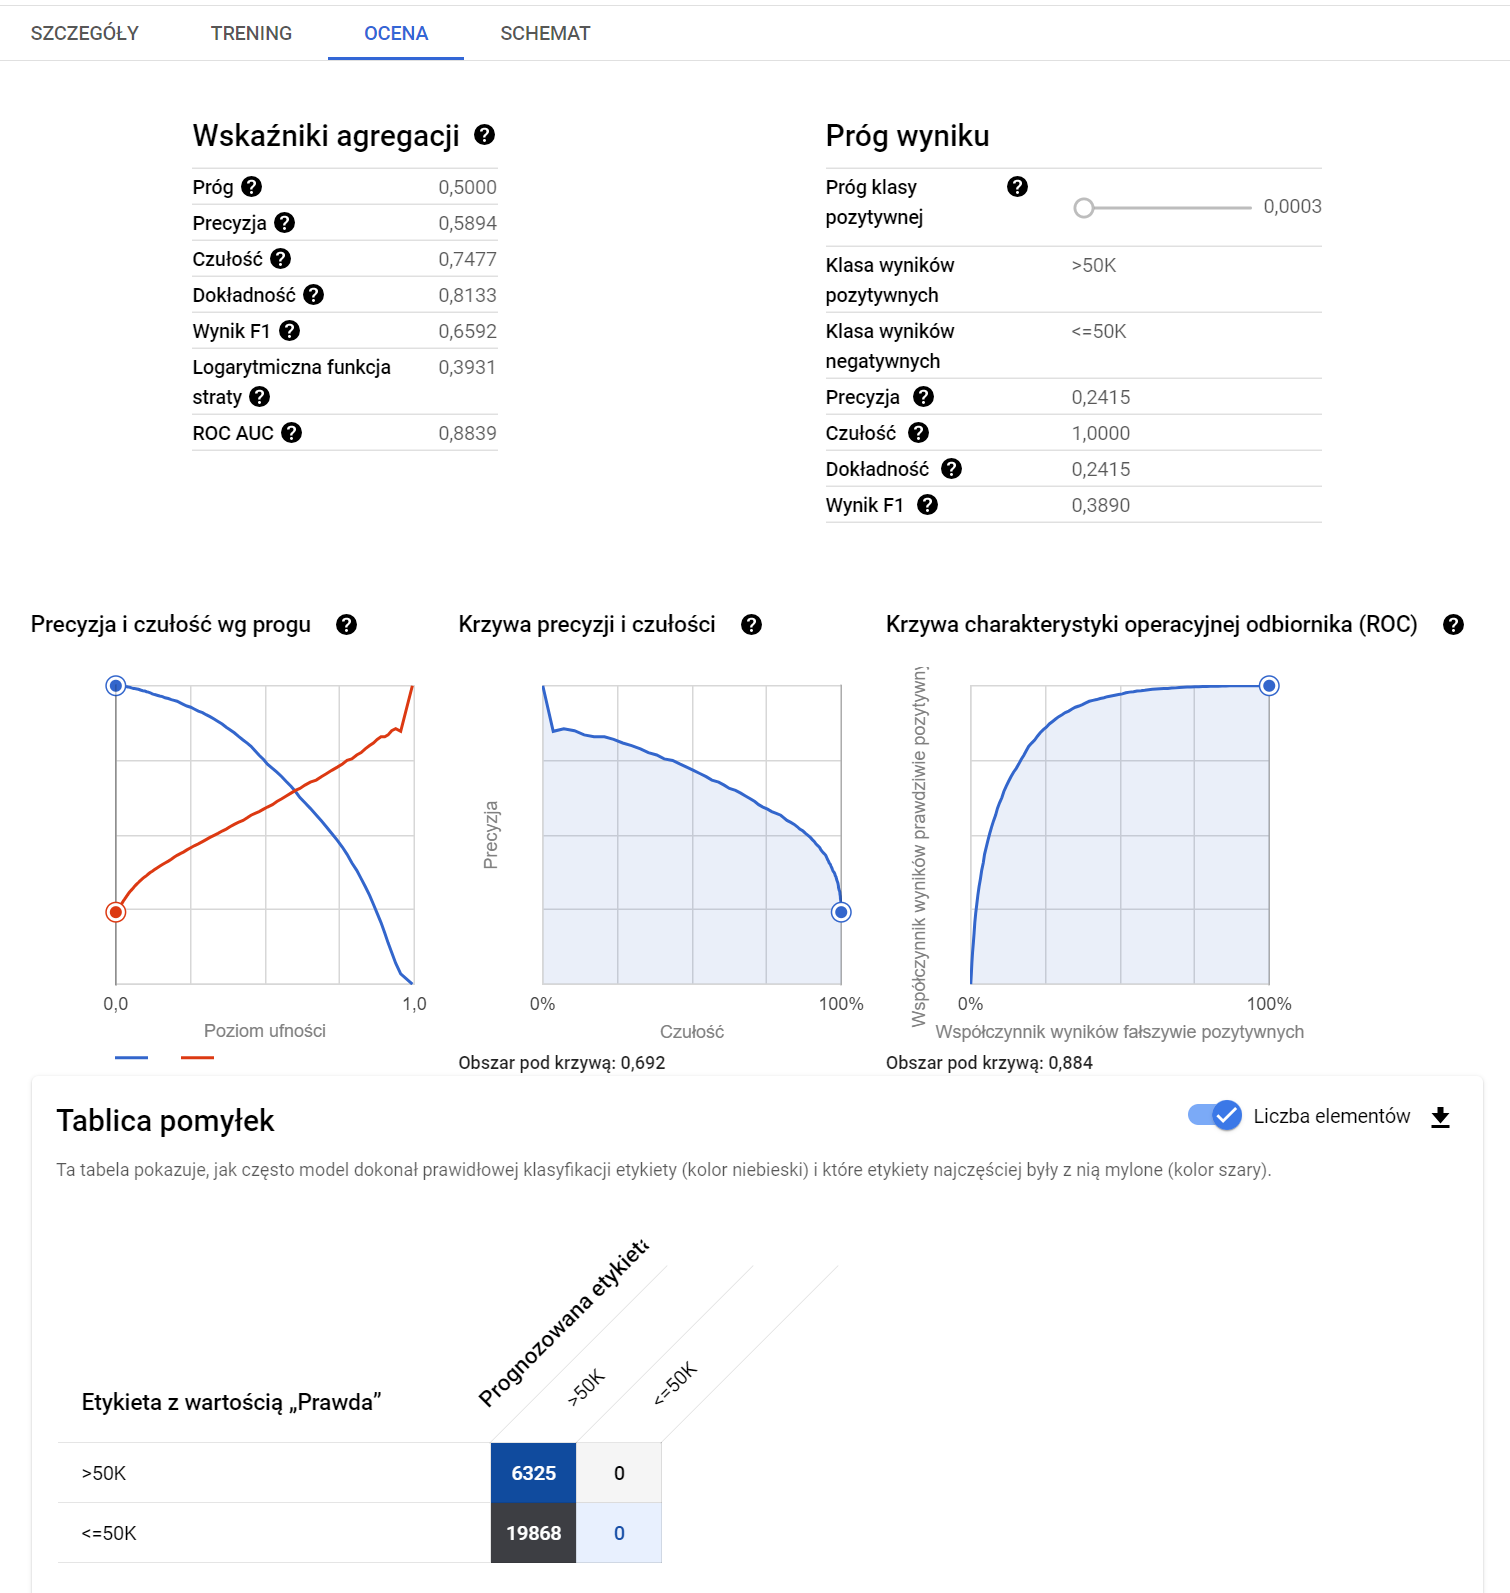

#Użyj funkcji do oceny swojego modelu (Krok 4)

##ML.EVALUATE

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE (MODEL `pmackowka_us.model_0071`,
    (
    SELECT
      *
    FROM
      `pmackowka_us.view_007`
    WHERE
      dataframe = 'evaluation'
    )
  )

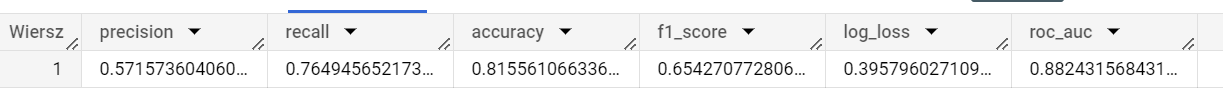

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE (MODEL `pmackowka_us.model_0073`,
    (
    SELECT
      *
    FROM
      `pmackowka_us.view_007`
    WHERE
      dataframe = 'evaluation'
    )
  )

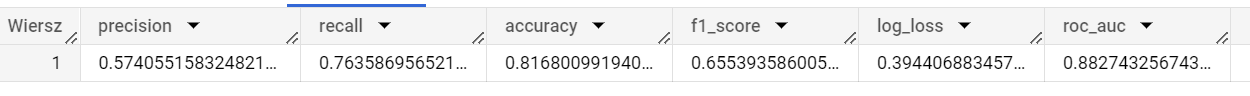

#Użyj funkcji do przewidzenia przedziału dochodów (Krok 5)

##ML.PREDICT

* Funkcja `ML.PREDICT` przewiduje wyniki przy użyciu modelu i danych z `pmackowka_us.model_0073`, przefiltrowanych w celu uwzględnienia tylko wierszy w ramce danych „przewidywania”. Instrukcja znajdująca się najwyżej SELECT pobiera wynik funkcji `ML.PREDICT`.

In [ ]:
%%bigquery

SELECT
  * except(age, workclass, marital_status, education_num, occupation, hours_per_week, dataframe)
FROM
  ML.PREDICT (MODEL `pmackowka_us.model_0073`,
    (
    SELECT
      *
    FROM
      `pmackowka_us.view_007`
    WHERE
      dataframe = 'prediction'
     )
  )

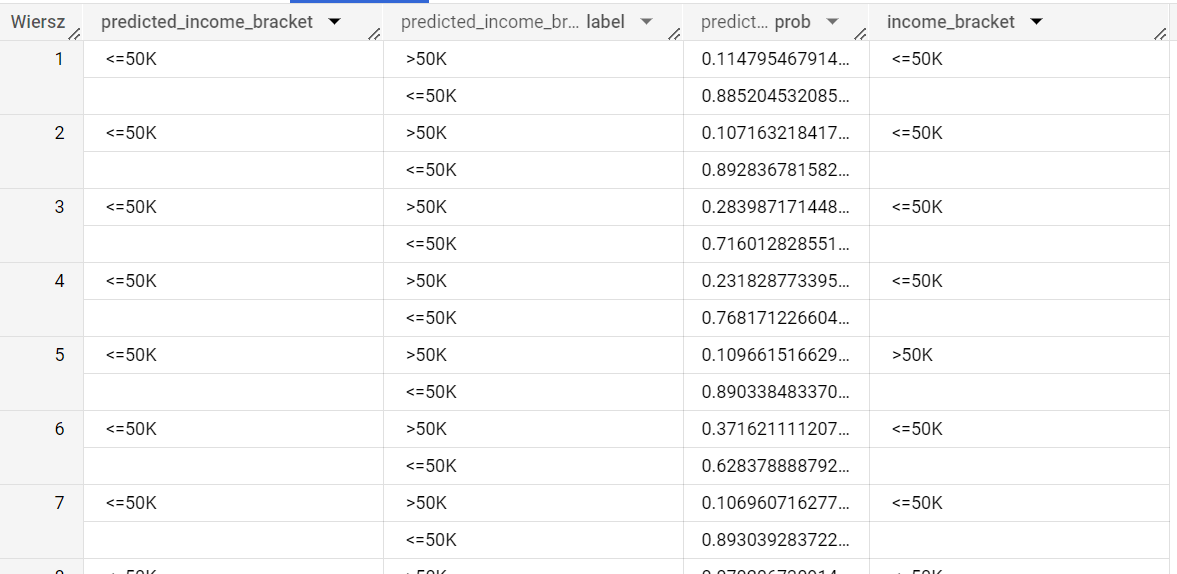

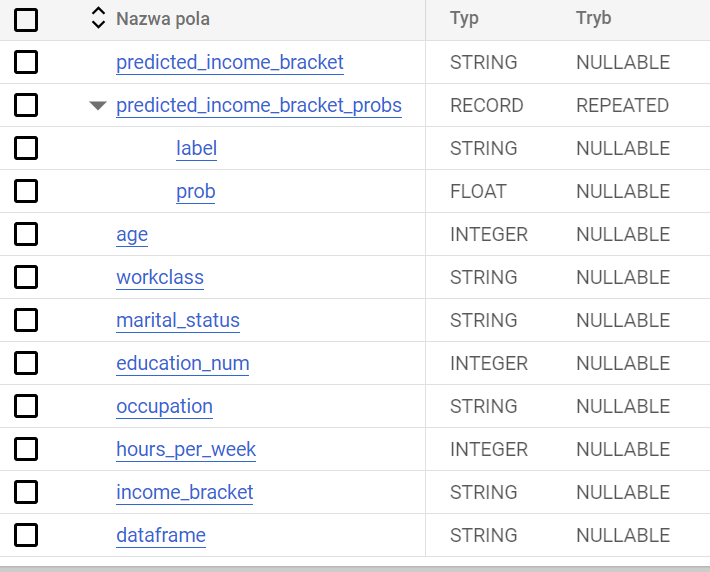

#Wyjaśnij wyniki przewidywań za pomocą możliwych do wyjaśnienia metod AI (Krok 6)

##ML.EXPLAIN_PREDICT

* `ML.EXPLAIN_PREDICT` jest rozszerzoną wersją `ML.PREDICT`. `ML.EXPLAIN_PREDICT` nie tylko generuje wyniki przewidywań, ale także generuje dodatkowe kolumny wyjaśniające wyniki przewidywań.

* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-explain-predict#mlexplain_predict_output

In [ ]:
%%bigquery

SELECT
*
FROM
ML.EXPLAIN_PREDICT(MODEL `pmackowka_us.model_0073`,
  (
  SELECT
    *
  FROM
    `pmackowka_us.view_007`
  WHERE
    dataframe = 'evaluation'),
  STRUCT(3 as top_k_features))

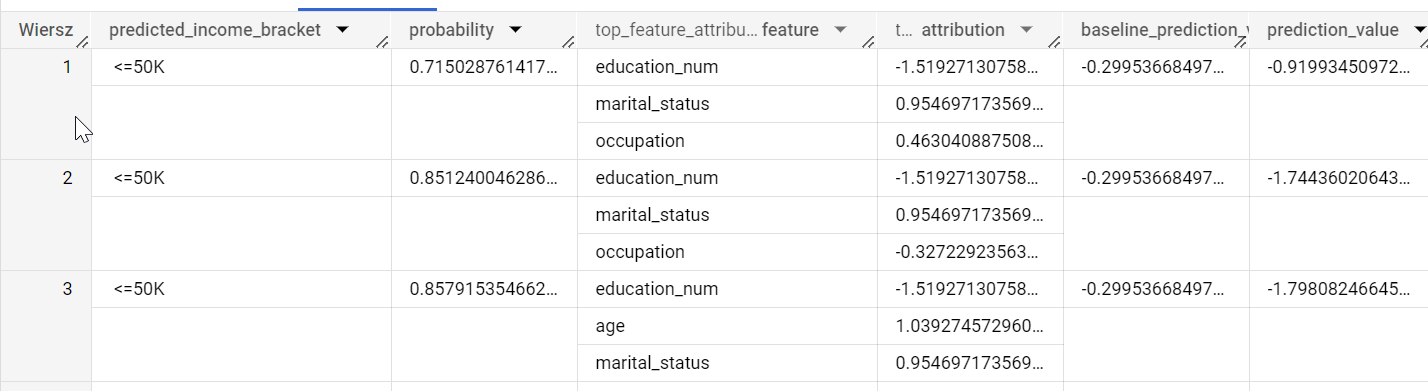

#Globalnie wyjaśnij swój model (Krok 7)

##ML.GLOBAL_EXPLAIN

In [ ]:
%%bigquery

  CREATE OR REPLACE MODEL
  pmackowka_us.model_0074
OPTIONS
  ( model_type='LOGISTIC_REG',
    auto_class_weights=TRUE,
    enable_global_explain=TRUE,
    input_label_cols=['income_bracket']
  ) AS
SELECT
  * EXCEPT(dataframe)
FROM
  pmackowka_us.view_007
WHERE
  dataframe = 'training'


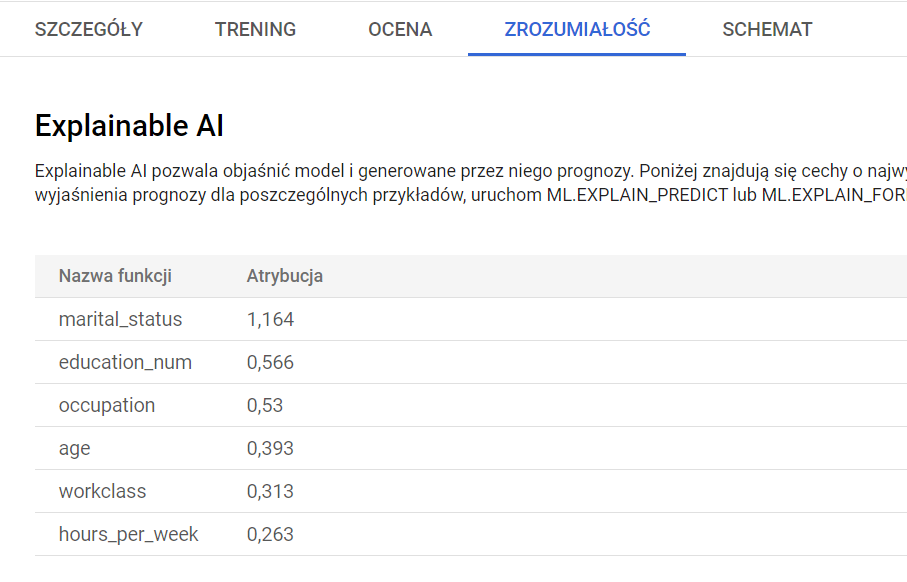

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL pmackowka_us.model_0074)

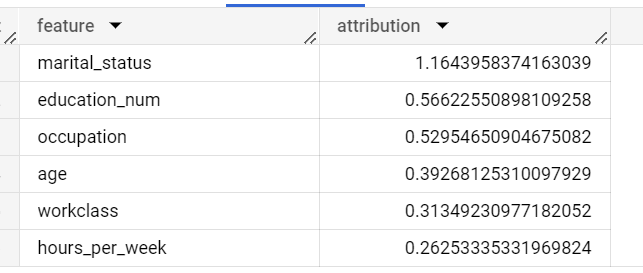